# Fraud Detection Project - CSE 891 @ Michigan State University
Justin Gould, Baylee Adams, Kyle Shope

Using a fraud dataset from Kaggle (https://www.kaggle.com/ntnu-testimon/banksim1), we attempt to apply data mining techniques to distinguish legitimate and fraudulent transactions, based on a variety of attributes.

The integrity of financial transactions is an incredibly important issue facing financial institutions and credit card companies alike. Having the ability to classify the legitimacy of a transaction to protect clients not only gives customers peace of mind, but is expensive. In 2016, according to CNBC, consumers lost more than $16B due to fraudulent transactions. With the scope of this issue in mind, our goal is to apply clustering and classification algorithms to determine if any given transaction follows similar behavior (classified as legitimate) or is an anomaly among that purchaser (flag as potentially fraudulent).

The data we have selected for this project can be found on Kaggle. This data is a table of transactions, transaction attributes (e.g. customer age, customer gender, ZIP code, merchant, purchase category, amount, etc.), and whether or not a transaction is fraudulent (0/1). With the amount of attribute data features within this dataset, we are confident that we will be able to build and train a classifier to detect fraudulent transactions by identifying transactions outside of typical purchase behavior across customer IDs.

# Required Packages

In [19]:
import pandas
import numpy
import string
from sklearn.model_selection import train_test_split
import sklearn.decomposition
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%pylab inline
import math
import statistics
import sklearn
from sklearn import neighbors
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, completeness_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import graphviz
import pydot
import pydotplus
from sklearn import svm
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files (x86)\\Graphviz2.38\\bin\\"
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Load the Data

In [4]:
#Original Data
fraud = pandas.read_csv("fraudData.csv")

#Upsampled Data - Training
fraudUp = pandas.read_csv("Upsampled.csv")

#Test Data (from Upsampled)
fraudTest = pandas.read_csv("Test Data.csv")

# Pre-process the Original Data

## Remove Apostrophes from Columns for Data Type Adjustment

In [6]:
fraud["customer"] = fraud["customer"].str.replace('[^\w\s]','')
fraud["age"] = fraud["age"].str.replace('[^\w\s]','')
fraud["gender"] = fraud["gender"].str.replace('[^\w\s]','')
fraud["zipcodeOri"] = fraud["zipcodeOri"].str.replace('[^\w\s]','')
fraud["merchant"] = fraud["merchant"].str.replace('[^\w\s]','')
fraud["zipMerchant"] = fraud["zipMerchant"].str.replace('[^\w\s]','')
fraud["category"] = fraud["category"].str.replace('[^\w\s]','')

## Fix Column Data Types

In [7]:
fraud["step"] = fraud["step"].astype("category")
fraud["customer"] = fraud["customer"].astype("category")
fraud["age"] = fraud["age"].astype("category")
fraud["gender"] = fraud["gender"].astype("category")
fraud["zipcodeOri"] = fraud["zipcodeOri"].astype("category")
fraud["merchant"] = fraud["merchant"].astype("category")
fraud["zipMerchant"] = fraud["zipMerchant"].astype("category")
fraud["category"] = fraud["category"].astype("category")
fraud["amount"] = fraud["amount"].astype(float)
fraud["fraud"] = fraud["fraud"].astype("category")

## Zip Columns not Necessary in Clustering Analysis - Eliminate

In [8]:
fraud = fraud.drop(["zipcodeOri"], axis = 1)
fraud = fraud.drop(["zipMerchant"], axis = 1)

## Change Categorical Columns to Binary Columns

In [9]:
fraudBinaryCols = pandas.get_dummies(fraud,columns = ["age","gender","merchant","category"])
fraudBinaryCols = fraudBinaryCols.drop(["customer"], axis = 1)

## Plot Distribution of Amount

Text(0.5,1,'Amount Rug Distribution')

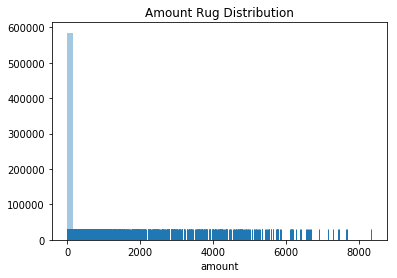

In [23]:
sns.distplot(fraud["amount"], kde=False, rug=True)
title("Amount Rug Distribution")

# Standardize the Data for Customer Clustering

## Original Data

In [26]:
scaler = StandardScaler()
fraudElim = fraudBinaryCols
fraudElim = fraudElim.drop(["step", "fraud"], axis = 1)
fraudStandScaler = scaler.fit_transform(fraudBinaryCols)
fraudStand = pandas.DataFrame(fraudStandScaler)
fraudStand.columns = list(fraudBinaryCols)
dataStandardized = fraudStand
dataStandardized["fraud"] = fraudBinaryCols["fraud"]

## Upsampled Data

In [69]:
scaler = StandardScaler()
fraudStandScaler = scaler.fit_transform(fraudUp)
fraudStand = pandas.DataFrame(fraudStandScaler)
fraudStand.columns = list(fraudBinaryCols)
dataStandardizedUP = fraudStand

## Test Data (from Upsampled)

In [70]:
fraudTestTest = fraudTest
fraudTestTest = fraudTestTest.drop("fraud", axis = 1)
scaler = StandardScaler()
fraudStandScaler = scaler.fit_transform(fraudTestTest)
fraudStand = pandas.DataFrame(fraudStandScaler)
fraudStand.columns = list(fraudTestTest)
dataStandardizedTest = fraudStand

# Attempt to Cluster Customers by Purchase Behavior

## Original Data - Standardized

### K-Means Clustering

k: 2  cost: 45582627.414760284
k: 3  cost: 44082528.24596801
k: 4  cost: 43113145.498852685
k: 5  cost: 41905419.66589378
k: 6  cost: 40600675.23316435
k: 7  cost: 39879098.315167114
k: 8  cost: 39451977.14252325
k: 9  cost: 38151369.41422901
k: 10  cost: 37548416.16936904


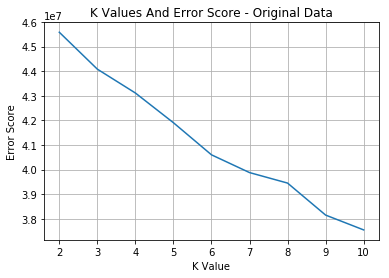

In [71]:
error = list()
kList = list()
for k in range(2, 11):
    kmeans_model = KMeans(n_clusters = k, random_state = 891).fit(dataStandardized)
    labels = kmeans_model.labels_
    labels = labels.tolist()
    cost = kmeans_model.inertia_
    error.append(cost)
    kList.append(k)
    print("k:", k, " cost:", cost)
plt.plot(kList, error)
plt.title("K Values And Error Score - Original Data")
plt.xlabel("K Value")
plt.ylabel("Error Score")
plt.grid()
plt.show()

### Using the Best Value of k

In [72]:
kmeans = KMeans(n_clusters = 4, random_state = 891).fit(dataStandardized)
labs = kmeans.labels_
labsList = labs.tolist()
dataStandardized["customerGroup"] = labsList
dataStandardized["fraud"] = fraud["fraud"]

### Examine Customer Group Distribution

Text(0.5,1,'Customer Group Breakdown - Original Data')

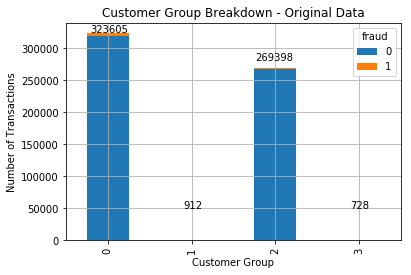

In [73]:
counts = dataStandardized.groupby("customerGroup").count()
counts = counts["step"].values.tolist()

dataStandardized.groupby(['customerGroup', 'fraud']).size().unstack().plot(kind='bar', stacked=True)
annotate(counts[0], [-0.21, 325000])
annotate(counts[1], [0.9, 50000])
annotate(counts[2], [1.76, 280000])
annotate(counts[3], [2.9, 50000])

ylabel("Number of Transactions")
xlabel("Customer Group")
grid()
title("Customer Group Breakdown - Original Data")

In [74]:
cust0 = dataStandardized.loc[dataStandardized['customerGroup'] == 0]
cust0 = cust0.reset_index(drop = True)
cust1 = dataStandardized.loc[dataStandardized['customerGroup'] == 1]
cust1 = cust1.reset_index(drop = True)
cust2 = dataStandardized.loc[dataStandardized['customerGroup'] == 2]
cust2 = cust2.reset_index(drop = True)
cust3 = dataStandardized.loc[dataStandardized['customerGroup'] == 3]
cust3 = cust3.reset_index(drop = True)

counts0 = cust0.groupby("fraud").count()
counts0 = counts0["step"].values.tolist()
nofraud0 = counts0[0]/sum(counts0)
fraud0 = counts0[1]/sum(counts0)
print("Customer Group 0:", "%s not fraud" % nofraud0, "| %s fraud" % fraud0)

counts1 = cust1.groupby("fraud").count()
counts1 = counts1["step"].values.tolist()
nofraud1 = counts1[0]/sum(counts1)
fraud1 = counts1[1]/sum(counts1)
print("Customer Group 1:", "%s not fraud" % nofraud1, "| %s fraud" % fraud1)

counts2 = cust2.groupby("fraud").count()
counts2 = counts2["step"].values.tolist()
nofraud2 = counts2[0]/sum(counts2)
fraud2 = counts2[1]/sum(counts2)
print("Customer Group 2:", "%s not fraud" % nofraud2, "| %s fraud" % fraud2)

counts3 = cust3.groupby("fraud").count()
counts3 = counts3["step"].values.tolist()
nofraud3 = counts3[0]/sum(counts3)
fraud3 = counts3[1]/sum(counts3)
print("Customer Group 3:", "%s not fraud" % nofraud3, "| %s fraud" % fraud3)

Customer Group 0: 0.9869006968371935 not fraud | 0.013099303162806508 fraud
Customer Group 1: 0.75 not fraud | 0.25 fraud
Customer Group 2: 0.9920006830043282 not fraud | 0.00799931699567183 fraud
Customer Group 3: 0.20604395604395603 not fraud | 0.7939560439560439 fraud


## Upsampled Data - Standardized

### K-Means Clustering

k: 2  cost: 70679353.74244852
k: 3  cost: 68894406.45436603
k: 4  cost: 66690476.96307046
k: 5  cost: 64420003.92912575
k: 6  cost: 62993960.50975509
k: 7  cost: 60770439.98079894
k: 8  cost: 59677998.21574084
k: 9  cost: 58416067.61473298
k: 10  cost: 55712832.18699259


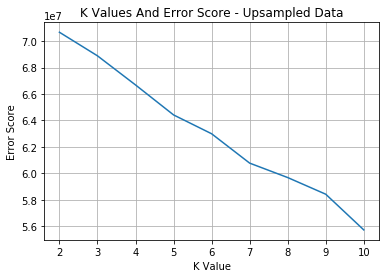

In [75]:
error = list()
kList = list()
for k in range(2, 11):
    kmeans_model = KMeans(n_clusters = k, random_state = 891).fit(dataStandardizedUP)
    labels = kmeans_model.labels_
    labels = labels.tolist()
    cost = kmeans_model.inertia_
    error.append(cost)
    kList.append(k)
    print("k:", k, " cost:", cost)
plot(kList, error)
title("K Values And Error Score - Upsampled Data")
xlabel("K Value")
ylabel("Error Score")
grid()
show()

### Using the Best Value of k

In [76]:
kmeans = KMeans(n_clusters = 5, random_state = 891).fit(dataStandardizedUP)
labs = kmeans.labels_
labsList = labs.tolist()
dataStandardizedUP["customerGroup"] = labsList
dataStandardizedUP["fraud"] = fraudUp["fraud"]

### Examine Customer Group Distribution

Text(0.5,1,'Customer Group Breakdown - Upsampled Data')

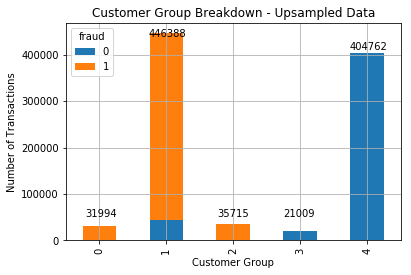

In [82]:
counts = dataStandardizedUP.groupby("customerGroup").count()
counts = counts["amount"].values.tolist()

dataStandardizedUP.groupby(['customerGroup', 'fraud']).size().unstack().plot(kind='bar', stacked=True)
annotate(counts[0], [-0.21, 50000])
annotate(counts[1], [0.73, 439000])
annotate(counts[2], [1.76, 50000])
annotate(counts[3], [2.74, 50000])
annotate(counts[4], [3.73, 410000])

ylabel("Number of Transactions")
xlabel("Customer Group")
grid()
title("Customer Group Breakdown - Upsampled Data")

In [86]:
cust0 = dataStandardizedUP.loc[dataStandardizedUP['customerGroup'] == 0]
cust0 = cust0.reset_index(drop = True)
cust1 = dataStandardizedUP.loc[dataStandardizedUP['customerGroup'] == 1]
cust1 = cust1.reset_index(drop = True)
cust2 = dataStandardizedUP.loc[dataStandardizedUP['customerGroup'] == 2]
cust2 = cust2.reset_index(drop = True)
cust3 = dataStandardizedUP.loc[dataStandardizedUP['customerGroup'] == 3]
cust3 = cust3.reset_index(drop = True)
cust4 = dataStandardizedUP.loc[dataStandardizedUP['customerGroup'] == 4]
cust4 = cust4.reset_index(drop = True)

counts0 = cust0.groupby("fraud").count()
counts0 = counts0["amount"].values.tolist()
nofraud0 = counts0[0]/sum(counts0)
fraud0 = counts0[1]/sum(counts0)
print("Customer Group 0:", "%s not fraud" % nofraud0, "| %s fraud" % fraud0)

counts1 = cust1.groupby("fraud").count()
counts1 = counts1["amount"].values.tolist()
nofraud1 = counts1[0]/sum(counts1)
fraud1 = counts1[1]/sum(counts1)
print("Customer Group 1:", "%s not fraud" % nofraud1, "| %s fraud" % fraud1)

counts2 = cust2.groupby("fraud").count()
counts2 = counts2["amount"].values.tolist()
nofraud2 = counts2[0]/sum(counts2)
fraud2 = counts2[1]/sum(counts2)
print("Customer Group 2:", "%s not fraud" % nofraud2, "| %s fraud" % fraud2)

counts3 = cust3.groupby("fraud").count()
counts3 = counts3["amount"].values.tolist()
nofraud3 = counts3[0]/sum(counts3)
print("Customer Group 3:", "%s not fraud" % nofraud3, "| %s fraud" % 0)

counts4 = cust4.groupby("fraud").count()
counts4 = counts4["amount"].values.tolist()
nofraud4 = counts4[0]/sum(counts4)
print("Customer Group 4:", "%s not fraud" % nofraud4, "| %s fraud" % 0)

Customer Group 0: 0.0006251172094767769 not fraud | 0.9993748827905232 fraud
Customer Group 1: 0.09862720324023047 not fraud | 0.9013727967597696 fraud
Customer Group 2: 0.003275934481310374 not fraud | 0.9967240655186896 fraud
Customer Group 3: 1.0 not fraud | 0 fraud
Customer Group 4: 1.0 not fraud | 0 fraud


## Test Data - Standardized

### K-Means Clustering

k: 2  cost: 8983754.79033209
k: 3  cost: 8759730.472061029
k: 4  cost: 8560138.352494117
k: 5  cost: 8313444.254985454
k: 6  cost: 8180582.2624179255
k: 7  cost: 8026945.636027608
k: 8  cost: 7644403.490412499
k: 9  cost: 7617370.704876197
k: 10  cost: 7444527.622420674


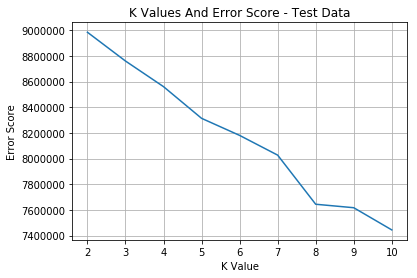

In [87]:
error = list()
kList = list()
for k in range(2, 11):
    kmeans_model = KMeans(n_clusters = k, random_state = 891).fit(dataStandardizedTest)
    labels = kmeans_model.labels_
    labels = labels.tolist()
    cost = kmeans_model.inertia_
    error.append(cost)
    kList.append(k)
    print("k:", k, " cost:", cost)
plot(kList, error)
title("K Values And Error Score - Test Data")
xlabel("K Value")
ylabel("Error Score")
grid()
show()

### Using the Best Value of k

In [88]:
kmeans = KMeans(n_clusters = 5, random_state = 891).fit(dataStandardizedTest)
labs = kmeans.labels_
labsList = labs.tolist()
dataStandardizedTest["customerGroup"] = labsList
dataStandardizedTest["fraud"] = fraudTest["fraud"]

### Examine Customer Group Distribution

Text(0.5,1,'Customer Group Breakdown - Test Data')

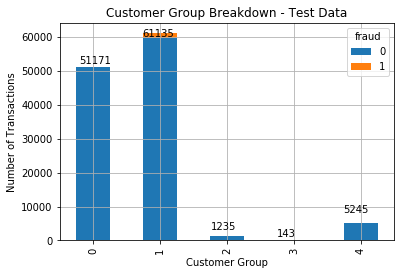

In [94]:
counts = dataStandardizedTest.groupby("customerGroup").count()
counts = counts["amount"].values.tolist()

dataStandardizedTest.groupby(['customerGroup', 'fraud']).size().unstack().plot(kind='bar', stacked=True)
annotate(counts[0], [-0.21, 52000])
annotate(counts[1], [0.73, 60000])
annotate(counts[2], [1.76, 3000])
annotate(counts[3], [2.74, 1000])
annotate(counts[4], [3.73, 8200])

ylabel("Number of Transactions")
xlabel("Customer Group")
grid()
title("Customer Group Breakdown - Test Data")

In [95]:
cust0 = dataStandardizedTest.loc[dataStandardizedTest['customerGroup'] == 0]
cust0 = cust0.reset_index(drop = True)
cust1 = dataStandardizedTest.loc[dataStandardizedTest['customerGroup'] == 1]
cust1 = cust1.reset_index(drop = True)
cust2 = dataStandardizedTest.loc[dataStandardizedTest['customerGroup'] == 2]
cust2 = cust2.reset_index(drop = True)
cust3 = dataStandardizedTest.loc[dataStandardizedTest['customerGroup'] == 3]
cust3 = cust3.reset_index(drop = True)
cust4 = dataStandardizedTest.loc[dataStandardizedTest['customerGroup'] == 4]
cust4 = cust4.reset_index(drop = True)

counts0 = cust0.groupby("fraud").count()
counts0 = counts0["amount"].values.tolist()
nofraud0 = counts0[0]/sum(counts0)
print("Customer Group 0:", "%s not fraud" % nofraud0)#, "%s fraud" % fraud0)

counts1 = cust1.groupby("fraud").count()
counts1 = counts1["amount"].values.tolist()
nofraud1 = counts1[0]/sum(counts1)
fraud1 = counts1[1]/sum(counts1)
print("Customer Group 1:", "%s not fraud" % nofraud1, "| %s fraud" % fraud1)

counts2 = cust2.groupby("fraud").count()
counts2 = counts2["amount"].values.tolist()
nofraud2 = counts2[0]/sum(counts2)
fraud2 = counts2[1]/sum(counts2)
print("Customer Group 2:", "%s not fraud" % nofraud2, "| %s fraud" % fraud2)

counts3 = cust3.groupby("fraud").count()
counts3 = counts3["amount"].values.tolist()
nofraud3 = counts3[0]/sum(counts3)
fraud3 = counts3[1]/sum(counts3)
print("Customer Group 3:", "%s not fraud" % nofraud3, "| %s fraud" % fraud3)

counts4 = cust4.groupby("fraud").count()
counts4 = counts4["amount"].values.tolist()
nofraud4 = counts4[0]/sum(counts4)
print("Customer Group 4:", "%s not fraud" % nofraud4)#, "%s fraud" % fraud4)

Customer Group 0: 1.0 not fraud
Customer Group 1: 0.9791281589923939 not fraud | 0.02087184100760612 fraud
Customer Group 2: 0.9748987854251012 not fraud | 0.025101214574898785 fraud
Customer Group 3: 0.2097902097902098 not fraud | 0.7902097902097902 fraud
Customer Group 4: 1.0 not fraud


# Split Data into Train Test

In [27]:
dataStandardized1 = dataStandardized
dataStandardized1 = dataStandardized1.drop("fraud", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(dataStandardized1, dataStandardized['fraud'], test_size = 0.40, random_state = 10, stratify = dataStandardized['fraud'])

# Naive Bayes

In [9]:
gnb = GaussianNB()
nb = cross_val_score(gnb, X_train, y_train, cv = 10)
print("Train Data:", numpy.mean(nb))

gnb = GaussianNB()
nb = cross_val_score(gnb, X_test, y_test, cv = 10)
print("Test Data:", numpy.mean(nb))

Train Data: 0.9507042088251954
Test Data: 0.9501341129450445


# Logistic Regression

In [18]:
reg = sklearn.linear_model.LogisticRegression()
reg.fit(X_train, y_train)
print(reg.coef_)
y_pred = reg.predict(X_test)
confMat = sklearn.metrics.confusion_matrix(y_test, y_pred)
confMatList = confMat.tolist()
TN = confMatList[0][0]
TP = confMatList[1][1]
FN = confMatList[1][0]
FP = confMatList[0][1]

precision = (TP) / (TP + FP)
recall = (TP) / (TP + FN)
print("Precision:", precision)
print("Recall:", recall)
confMat

[[ 0.34564236  1.45480284 -0.06327624  0.01653141  0.00553531 -0.02211753
   0.01278538  0.01781141 -0.0161141  -0.0214958  -0.0214958   0.09324961
  -0.08612507 -0.08888809 -0.28946347 -0.01800635  0.294898    0.098587
  -0.02336559 -0.08820967  0.08558719 -0.11031536 -0.06295951  0.26915115
   0.26849323 -0.09250767  0.07869496 -0.03713408  0.09439651  0.10722117
   0.10784619 -0.09594644 -0.16007575 -0.12007918 -0.09326862  0.16978337
   0.13507215 -0.22846964 -0.27896592  0.13845099  0.01721911  0.29293434
   0.17480885  0.0596751  -0.06294638 -0.1013012   0.1081484  -0.11461935
   0.54606914 -0.13131509  0.15851804  0.26758384 -0.01483232  0.12059642
   0.06384526  0.18116047  0.20074922  0.30185636  0.10018849 -0.13240982
   0.15088436  0.02576749 -0.09346524  0.31070779  0.26915115 -0.02747386
  -0.02397785 -0.13240982  0.02001663  0.01457554  0.06923648  0.30185636
   0.14598932  0.13507215  0.29679227  0.06745923 -0.30750631  0.01994153
   0.22909168]]
Precision: 0.88869936034

array([[234717,    261],
       [   796,   2084]], dtype=int64)

# Neural Network

In [28]:
reg = MLPRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred = numpy.rint(y_pred)

confMat = sklearn.metrics.confusion_matrix(y_test, y_pred)
confMatList = confMat.tolist()
TN = confMatList[0][0]
TP = confMatList[1][1]
FN = confMatList[1][0]
FP = confMatList[0][1]

precision = (TP) / (TP + FP)
recall = (TP) / (TP + FN)
print("Precision:", precision)
print("Recall:", recall)
confMat

Precision: 0.8720699245133094
Recall: 0.7624175060784995


array([[234656,    322,      0],
       [   684,   2195,      1],
       [     0,      0,      0]], dtype=int64)

# Decision Tree - Different Max_Depth Values

## Determine Best Max_Depth Value

In [28]:
accuracy = []
for x in range(2, 101):
    print(x)
    clf = tree.DecisionTreeClassifier(max_depth = x)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confMat = sklearn.metrics.confusion_matrix(y_test, y_pred)
    confMatList = confMat.tolist()
    TN = confMatList[0][0]
    TP = confMatList[1][1]
    FN = confMatList[1][0]
    FP = confMatList[0][1]

    precision = (TP) / (TP + FP)
    recall = (TP) / (TP + FN)
    f1 = 2*((precision * recall) / (precision + recall))
    accuracy.append([x, precision, recall, f1])
    
accuracyDF = pandas.DataFrame(data = accuracy, columns = ["k", "precision", "recall", "f-measure"])
accuracyDF = accuracyDF.sort_values(by = ["precision", "recall"], ascending = False)
accuracyDF

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


,k,precision,recall,f-measure
6,8,0.903128,0.721875,0.802393
3,5,0.900415,0.678125,0.773619
4,6,0.900312,0.702431,0.789155
2,4,0.893855,0.666667,0.763723
5,7,0.888984,0.720139,0.795703
8,10,0.884826,0.730903,0.800532
7,9,0.879768,0.736806,0.801965
9,11,0.879079,0.729514,0.797343
10,12,0.875517,0.735069,0.799169
1,3,0.875224,0.679514,0.765051


## Apply Best Value

In [32]:
maxVals = list(accuracyDF["k"])
best = maxVals[0]
clf = tree.DecisionTreeClassifier(max_depth = best)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy.append([x, sklearn.metrics.accuracy_score(y_test, y_pred)])
dot_data = tree.export_graphviz(clf, out_file = None) 
graph = graphviz.Source(dot_data) 
graph.render("fraudDT")

#print("Accuracy:", sklearn.metrics.accuracy_score(y_test, y_pred))
confMat = sklearn.metrics.confusion_matrix(y_test, y_pred)
confMatList = confMat.tolist()
TN = confMatList[0][0]
TP = confMatList[1][1]
FN = confMatList[1][0]
FP = confMatList[0][1]

precision = (TP) / (TP + FP)
recall = (TP) / (TP + FN)
print("Precision:", precision)
print("Recall:", recall)
confMat

Precision: 0.9026510212950891
Recall: 0.7211805555555556


array([[234754,    224],
       [   803,   2077]], dtype=int64)

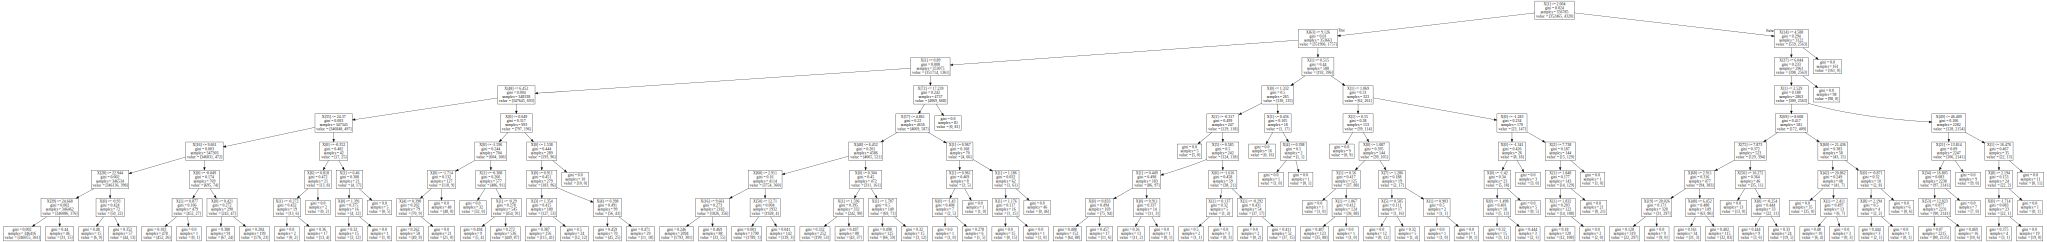

In [33]:
graph